## Predicción de la próxima palabra

El objetivo de este notebook es entrenar un modelo de lenguaje basado en arquitecturas recurrentes a partir de un corpus.

El texto a utilizar es el artículo *Natural language processing* de Wikipedia. Se realizaron algunas modificaciones menores al texto, tales como eliminar links a referencias o citas, a los fines de obtener un corpus más apto para este ejercicio. Aun así, no se altera el contenido en sí del articulo.

En el transcurso del ejercicio se explorarán técnicas de generación de secuencias y se medirá la calidad de las mismas calculando la *perplejidad*.

### Librerías

In [136]:
import re
import numpy as np
import pandas as pd

from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy

from matplotlib import pyplot as plt
import seaborn as sns

### 1- Carga de datos y preprocesamiento

In [137]:
!gdown 1Baa3ly1gQn5adEoU8i-RiwoJrX4UW3IR

Downloading...
From: https://drive.google.com/uc?id=1Baa3ly1gQn5adEoU8i-RiwoJrX4UW3IR
To: /content/Natural language processing - Wikipedia.txt
100% 30.7k/30.7k [00:00<00:00, 57.2MB/s]


In [138]:
with open('Natural language processing - Wikipedia.txt', 'r', encoding='utf-8-sig') as file:
    text = file.read().lower()

# Dividir el corpus en oraciones.
sentences = re.split(r'(?<=\.)\s+', text.strip())

# Construir un dataframe de manera que cada documento sea una oración.
df = pd.DataFrame(sentences, columns=['document'])
for document in df.iloc[:5].values:
    print(document)

print('\nCantidad de documentos:', df.shape[0])

['natural language processing (nlp) is an interdisciplinary subfield of computer science and information retrieval.']
['it is primarily concerned with giving computers the ability to support and manipulate human language.']
['it involves processing natural language datasets, such as text corpora or speech corpora, using either rule-based or probabilistic (i.e.']
['statistical and, most recently, neural network-based) machine learning approaches.']
['the goal is a computer capable of "understanding" the contents of documents, including the contextual nuances of the language within them.']

Cantidad de documentos: 250


In [139]:
# Guardar cada oración en una lista.
text = list(df.loc[:, 'document'])
text[:10]

['natural language processing (nlp) is an interdisciplinary subfield of computer science and information retrieval.',
 'it is primarily concerned with giving computers the ability to support and manipulate human language.',
 'it involves processing natural language datasets, such as text corpora or speech corpora, using either rule-based or probabilistic (i.e.',
 'statistical and, most recently, neural network-based) machine learning approaches.',
 'the goal is a computer capable of "understanding" the contents of documents, including the contextual nuances of the language within them.',
 'to this end, natural language processing often borrows ideas from theoretical linguistics.',
 'the technology can then accurately extract information and insights contained in the documents as well as categorize and organize the documents themselves.',
 'challenges in natural language processing frequently involve speech recognition, natural-language understanding, and natural-language generation.',


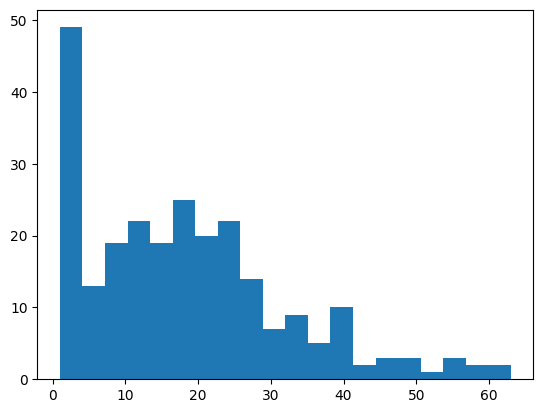

In [140]:
# Segmentar el texto.
segmented_sentences = [text_to_word_sequence(sentence) for sentence in text]

# Obtener la longitudes de cada oración.
length_sentences = [len(sentence) for sentence in segmented_sentences]

# Graficar un histograma con las longitudes.
plt.hist(length_sentences, bins=20)
plt.show()

In [141]:
segmented_sentences[:10]

[['natural',
  'language',
  'processing',
  'nlp',
  'is',
  'an',
  'interdisciplinary',
  'subfield',
  'of',
  'computer',
  'science',
  'and',
  'information',
  'retrieval'],
 ['it',
  'is',
  'primarily',
  'concerned',
  'with',
  'giving',
  'computers',
  'the',
  'ability',
  'to',
  'support',
  'and',
  'manipulate',
  'human',
  'language'],
 ['it',
  'involves',
  'processing',
  'natural',
  'language',
  'datasets',
  'such',
  'as',
  'text',
  'corpora',
  'or',
  'speech',
  'corpora',
  'using',
  'either',
  'rule',
  'based',
  'or',
  'probabilistic',
  'i',
  'e'],
 ['statistical',
  'and',
  'most',
  'recently',
  'neural',
  'network',
  'based',
  'machine',
  'learning',
  'approaches'],
 ['the',
  'goal',
  'is',
  'a',
  'computer',
  'capable',
  'of',
  'understanding',
  'the',
  'contents',
  'of',
  'documents',
  'including',
  'the',
  'contextual',
  'nuances',
  'of',
  'the',
  'language',
  'within',
  'them'],
 ['to',
  'this',
  'end',
  'n

In [142]:
max_context_size = int(np.ceil(np.mean(length_sentences))) # Criterio de la media
#max_context_size = int(np.percentile(length_sentences, 90) - 1)
print(f'max_context_size: {max_context_size}')

max_context_size: 19


### 2- Tokenizar

In [143]:
tok = Tokenizer()
tok.fit_on_texts(segmented_sentences)

# Convertir palabras tokenizadas a números.
tokenized_sentences = tok.texts_to_sequences(segmented_sentences)
tokenized_sentences[:5]

[[15, 8, 38, 18, 7, 39, 227, 564, 2, 65, 168, 4, 63, 565],
 [55, 7, 566, 228, 17, 567, 568, 1, 569, 6, 570, 4, 326, 83, 8],
 [55,
  132,
  38,
  15,
  8,
  571,
  20,
  9,
  10,
  169,
  12,
  26,
  169,
  109,
  170,
  64,
  31,
  12,
  171,
  97,
  11],
 [40, 4, 66, 327, 44, 133, 31, 32, 47, 98],
 [1,
  229,
  7,
  3,
  65,
  572,
  2,
  69,
  1,
  573,
  2,
  172,
  328,
  1,
  574,
  575,
  2,
  1,
  8,
  173,
  329]]

### 3- Dividir el dataset. Preprocesar generando secuencias de igual tamaño

In [144]:
tokenized_sentences_train, tokenized_sentences_val, _, _ = train_test_split(
    tokenized_sentences,
    tokenized_sentences,
    test_size=0.2,
    random_state=42)

tok_sent = []
for sent in tokenized_sentences_train:
  # Si la secuencia tiene más términos que el tamaño de contexto máximo,
  # armar varias sub-secuencias de tamaño máximo.
  if len(sent) > (max_context_size + 1):
    extra = len(sent)-(max_context_size + 1) + 1
    for i in range(extra):
      tok_sent.append(sent[i:i+max_context_size+1])
  else: # si la secuencia tiene menos términos el tamaño de contexto máximo, dejar la secuencia como está
    tok_sent.append(sent)

print('Oraciones tokenizadas', len(tok_sent))

tok_sent_augm = []
for sent in tok_sent:
  # Generamos todas las sub-secuencias.
  subseq = [sent[:i+2] for i in range(len(sent) - 1)]
  # Agregar padding al tamaño de contexto máximo.
  tok_sent_augm.append(pad_sequences(subseq, maxlen=max_context_size + 1, padding='pre'))

# Concatenar todas las secuencias en un único array de numpy.
train_seqs = np.concatenate(tok_sent_augm, axis=0)
print('Shape de secuencias de entrenamiento', train_seqs.shape)

X = train_seqs[:, :-1]
y = train_seqs[:, 1:]

Oraciones tokenizadas 1183
Shape de secuencias de entrenamiento (21228, 20)


### 4- Palabras del vocabulario

In [145]:
tok.index_word

{1: 'the',
 2: 'of',
 3: 'a',
 4: 'and',
 5: 'in',
 6: 'to',
 7: 'is',
 8: 'language',
 9: 'as',
 10: 'text',
 11: 'e',
 12: 'or',
 13: 'that',
 14: 'for',
 15: 'natural',
 16: 'g',
 17: 'with',
 18: 'nlp',
 19: 'words',
 20: 'such',
 21: 'on',
 22: 'given',
 23: 'are',
 24: 'by',
 25: 'this',
 26: 'speech',
 27: 'can',
 28: 'which',
 29: 'be',
 30: 'word',
 31: 'based',
 32: 'machine',
 33: 'from',
 34: 'was',
 35: 'other',
 36: 'semantic',
 37: 'sentence',
 38: 'processing',
 39: 'an',
 40: 'statistical',
 41: 'tasks',
 42: 'parsing',
 43: 'semantics',
 44: 'neural',
 45: 'systems',
 46: 'cognitive',
 47: 'learning',
 48: 'more',
 49: 'into',
 50: 'have',
 51: 'not',
 52: 'task',
 53: 'languages',
 54: 'since',
 55: 'it',
 56: 'data',
 57: 'translation',
 58: 'grammar',
 59: 'approach',
 60: 'used',
 61: 'also',
 62: 'analysis',
 63: 'information',
 64: 'rule',
 65: 'computer',
 66: 'most',
 67: 'research',
 68: 'methods',
 69: 'understanding',
 70: 'linguistics',
 71: 'recognition',

### 5- Cantidad de palabras en vocabulario. Índice de cada una

In [146]:
vocab_size = len(tok.word_counts)
print('Cantidad de palabras en vocabulario', vocab_size)
print('Índices', tok.word_index)

Cantidad de palabras en vocabulario 1349
Índices {'the': 1, 'of': 2, 'a': 3, 'and': 4, 'in': 5, 'to': 6, 'is': 7, 'language': 8, 'as': 9, 'text': 10, 'e': 11, 'or': 12, 'that': 13, 'for': 14, 'natural': 15, 'g': 16, 'with': 17, 'nlp': 18, 'words': 19, 'such': 20, 'on': 21, 'given': 22, 'are': 23, 'by': 24, 'this': 25, 'speech': 26, 'can': 27, 'which': 28, 'be': 29, 'word': 30, 'based': 31, 'machine': 32, 'from': 33, 'was': 34, 'other': 35, 'semantic': 36, 'sentence': 37, 'processing': 38, 'an': 39, 'statistical': 40, 'tasks': 41, 'parsing': 42, 'semantics': 43, 'neural': 44, 'systems': 45, 'cognitive': 46, 'learning': 47, 'more': 48, 'into': 49, 'have': 50, 'not': 51, 'task': 52, 'languages': 53, 'since': 54, 'it': 55, 'data': 56, 'translation': 57, 'grammar': 58, 'approach': 59, 'used': 60, 'also': 61, 'analysis': 62, 'information': 63, 'rule': 64, 'computer': 65, 'most': 66, 'research': 67, 'methods': 68, 'understanding': 69, 'linguistics': 70, 'recognition': 71, 'has': 72, 'rules': 

### 6- Definir el modelo

In [147]:
model = Sequential([
    Embedding(input_dim=vocab_size + 1, output_dim=50, input_shape=(None,)),
    LSTM(100, return_sequences=True),
    LSTM(100, return_sequences=True),
    Dense(vocab_size + 1, activation='softmax')
])
model.compile(loss=SparseCategoricalCrossentropy(), optimizer='rmsprop')
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, None, 50)          67500     
                                                                 
 lstm_18 (LSTM)              (None, None, 100)         60400     
                                                                 
 lstm_19 (LSTM)              (None, None, 100)         80400     
                                                                 
 dense_9 (Dense)             (None, None, 1350)        136350    
                                                                 
Total params: 344650 (1.31 MB)
Trainable params: 344650 (1.31 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 7- Definir como callback a la métrica perplexity

In [148]:
class PplCallback(keras.callbacks.Callback):
    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl, patience=5):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad y la paciencia para detener el entrenamiento.
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.history_ppl = history_ppl
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(len_seq)]
        self.target.extend([seq[i] for i in range(len_seq)])

        if len(subseq) !=0 :

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)

    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start, end), self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        self.history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if self.patience is not None:
            if current_score < self.min_score:
                self.min_score = current_score
                self.model.save('my_model')
                print('Saved new model!')
                self.patience_counter = 0
            else:
                self.patience_counter += 1
                if self.patience_counter == self.patience:
                    print('Stopping training...')
                    self.model.stop_training = True


### 8- Entrenamiento

In [149]:
history_ppl = []
hist = model.fit(
    X,
    y,
    epochs=20,
    callbacks=[PplCallback(tokenized_sentences_val, history_ppl, patience=3)],
    batch_size=32)

Epoch 1/20
663/664 [============================>.] - ETA: 0s - loss: 3.8290
 mean perplexity: 3819.080259549666 

Saved new model!
664/664 [==============================] - 67s 95ms/step - loss: 3.8289
Epoch 2/20
663/664 [============================>.] - ETA: 0s - loss: 3.3978
 mean perplexity: 4028.3155015424454 

664/664 [==============================] - 48s 72ms/step - loss: 3.3979
Epoch 3/20
663/664 [============================>.] - ETA: 0s - loss: 3.0695
 mean perplexity: 4258.34136690368 

664/664 [==============================] - 48s 73ms/step - loss: 3.0696
Epoch 4/20
664/664 [==============================] - ETA: 0s - loss: 2.7976
 mean perplexity: 3442.129771040767 

Saved new model!
664/664 [==============================] - 61s 91ms/step - loss: 2.7976
Epoch 5/20
663/664 [============================>.] - ETA: 0s - loss: 2.5849
 mean perplexity: 3620.7206762163282 

664/664 [==============================] - 48s 72ms/step - loss: 2.5848
Epoch 6/20
664/664 [==========

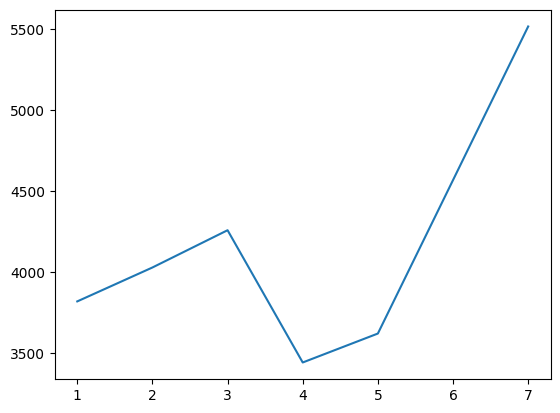

In [150]:
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count, y=history_ppl)
plt.show()